# Discrete Anomaly Detection

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

## Wrangle Data

In [2]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
len(df)

13974

In [4]:
for col in df.columns:
    print(df[col].value_counts())
    print(" ")

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
35.175.171.137        2
70.121.214.34         2
52.87.230.102         2
54.172.14.223         1
3.92.201.136          1
34.207.64.242         1
35.174.209.2          1
54.145.52.184         1
52.90.165.200         1
52.91.30.150          1
3.88.129.158          1
45.23.250.16          1
34.229.70.250         1
Name: ip, dtype: int64
 
16/Apr/2019 19:56:10    9
16/Apr/2019 19:49:58    8
16/Apr/2019 20:01:30    7
16/Apr/2019 20:02:59    6
16/Apr/2019 20:12:23    6
                       ..
17/Apr/2019 12:55:04    1
17/Apr/2019 01:46:42    1
16/Apr/2019 21:55:55    1
16/Apr/2019 22:00:42    1
16/Apr/2019 20:06:24    1
Name: timestamp, Length: 9953, dtype: int64
 
GET    13974
Name: request_method, dtype: int64
 
/api/v1/sales?page=2                       709
/api/v1/items                              464
/api/v1/items?page=2                       

In [5]:
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [6]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


## IP Address

In [7]:
df.ip.value_counts().head()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
Name: ip, dtype: int64

In [8]:
df.ip.value_counts(normalize=True).head()

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
68.201.219.223    0.001503
Name: ip, dtype: float64

In [9]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [10]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,11998,0.858595
173.173.113.51,1059,0.075784
72.181.113.170,613,0.043867
72.181.105.81,246,0.017604
68.201.219.223,21,0.001503


<ipython-input-11-80e94fdeef90>:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  title = ip_counts.set(Title = "IP Addresses by Count")


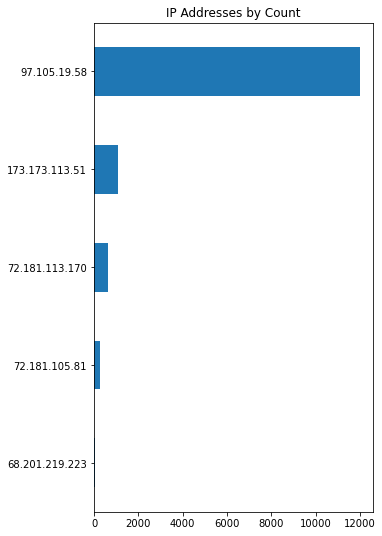

In [11]:
ip_counts = ip_df['count'].sort_values().tail(5).plot.barh(figsize=(5, 9))
title = ip_counts.set(Title = "IP Addresses by Count")


In [12]:
ip_value_counts = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index()

In [13]:
ip_value_counts.head()

,index,ip
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21


In [14]:
ip_value_counts = ip_value_counts.rename(columns = {'index': 'ip', 'ip': 'value_count'})

In [15]:
ip_value_counts.head()

,ip,value_count
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21


In [16]:
ip_probability = pd.DataFrame(df.ip.value_counts(dropna = False)/df.ip.count())
ip_probability = ip_probability.reset_index()

In [17]:
ip_probability.head()

,index,ip
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,68.201.219.223,0.001503


In [18]:
ip_probability = ip_probability.rename(columns = {'index': 'ip', 'ip': 'probability'})

In [19]:
ip_probability.head()

,ip,probability
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,68.201.219.223,0.001503


In [20]:
ip = ip_value_counts.merge(ip_probability)

In [21]:
ip

,ip,value_count,probability
0,97.105.19.58,11998,0.858595
1,173.173.113.51,1059,0.075784
2,72.181.113.170,613,0.043867
3,72.181.105.81,246,0.017604
4,68.201.219.223,21,0.001503
5,24.26.242.9,21,0.001503
6,35.175.171.137,2,0.000143
7,70.121.214.34,2,0.000143
8,52.87.230.102,2,0.000143
9,54.172.14.223,1,0.000072


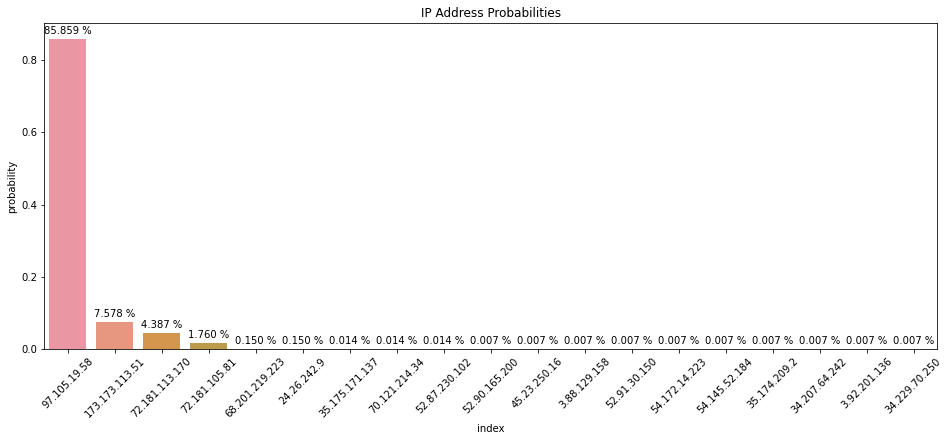

In [22]:
sns.set_palette= "bright"
plt.figure(figsize=(16, 6))
splot = sns.barplot(x='index', y='ip', data=df.ip.value_counts(normalize=True).reset_index().sort_values(
        by='ip', ascending=False))
plt.xticks(rotation= 45)
for p in splot.patches:
    splot.annotate(format(p.get_height() * 100, '.3f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
plt.title('IP Address Probabilities')
plt.ylabel('probability')
plt.show()

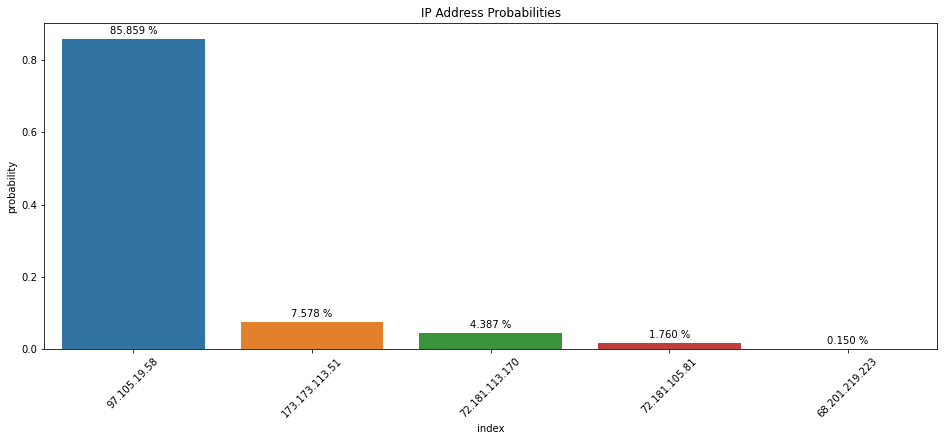

In [23]:
sns.set_palette= "bright"
plt.figure(figsize=(16, 6))
splot = sns.barplot(x='index', y='ip', data=df.ip.value_counts(normalize=True).reset_index().sort_values(
        by='ip', ascending=False).head())
plt.xticks(rotation= 45)
for p in splot.patches:
    splot.annotate(format(p.get_height() * 100, '.3f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
plt.title('IP Address Probabilities')
plt.ylabel('probability')
plt.show()

### Takeaway

Some of the IP addresses only have one visit. However, that's not unreasonable, as one IP address may have only visited our website once.

## Request Path

In [24]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [25]:
request_path = value_counts_and_frequencies(df.request_path)

In [26]:
len(request_path)

218

In [27]:
request_path.head()

,count,proba
/api/v1/sales?page=2,709,0.050737
/api/v1/items,464,0.033205
/api/v1/items?page=2,291,0.020824
/api/v1/items?page=3,219,0.015672
/api/v1/stores,162,0.011593


In [28]:
request_path.tail()

,count,proba
/api/v1/stores?page=666,1,0.000072
/api/v1//api/v1/items,1,0.000072
/api/v1/items?page=99999999999999999998,1,0.000072
/api/v1/helloclass!,1,0.000072
/api/v1/I_DIDNT_DO_IT!!!!,1,0.000072


In [85]:
request_path[request_path.proba < 0.0001]

,count,proba
/api/v1/stores?page=2,1,0.000072
/api/v1/items/api/v1/items?page=3,1,0.000072
/api/v1/items?page=4,1,0.000072
/api/v1//api/v1/items/next_page,1,0.000072
/api/v1/items?page=0,1,0.000072
/api/v1,1,0.000072
/api/v1/stores?page=999,1,0.000072
/api/V1/HiZach!,1,0.000072
/api/v1/items&page=0,1,0.000072
/api/v1/stores?page=666,1,0.000072


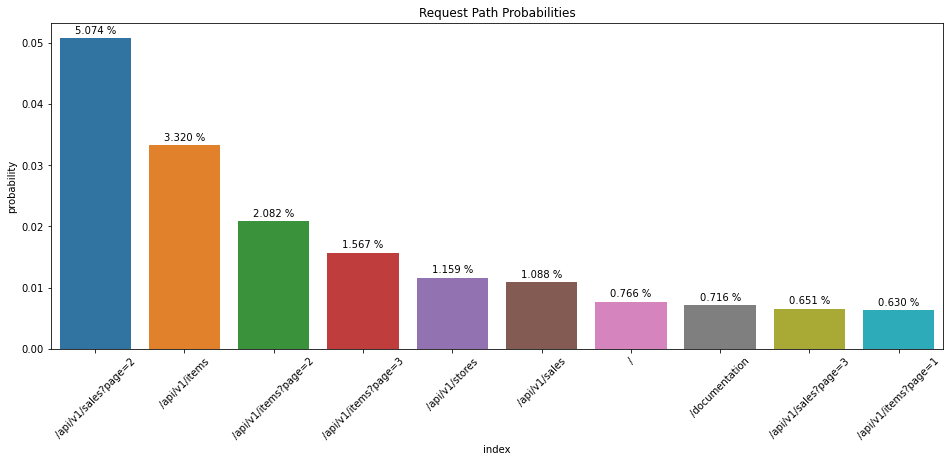

In [29]:
plt.figure(figsize=(16, 6))
splot = sns.barplot(x='index', y='request_path', data=df.request_path.value_counts(normalize=True).reset_index().sort_values(
        by='request_path', ascending=False).head(10))
plt.xticks(rotation= 45)
for p in splot.patches:
    splot.annotate(format(p.get_height() * 100, '.3f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
plt.title('Request Path Probabilities')
plt.ylabel('probability')
plt.show()

### Key Takeaways

Many of our request plans only have one hit, but that is not unreasonable.

## HTTP Version

In [30]:
df.http_version.value_counts()

HTTP/1.1    13974
Name: http_version, dtype: int64

## Status Code

In [31]:
df.status_code.value_counts()

200    13958
499       16
Name: status_code, dtype: int64

**Note**

The status code 200 indicates sucess. The code 499 indicates a failure.

In [32]:
status_code = value_counts_and_frequencies(df.status_code)

In [33]:
status_code

,count,proba
200,13958,0.998855
499,16,0.001145


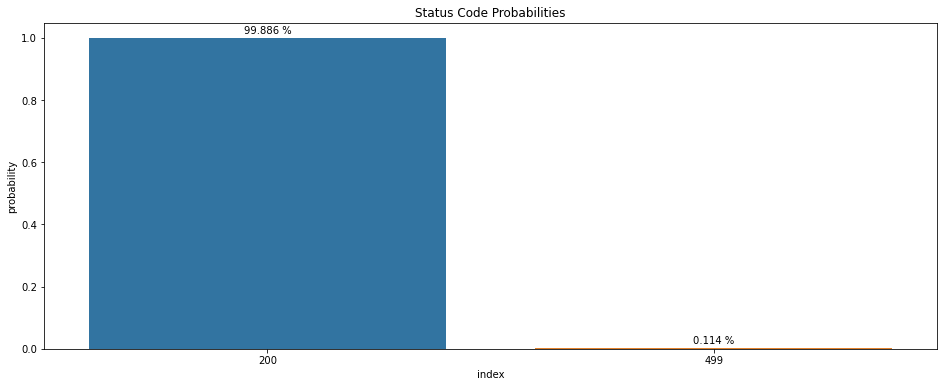

In [34]:
plt.figure(figsize=(16, 6))
splot = sns.barplot(x='index', y='status_code', data=df.status_code.value_counts(normalize=True).reset_index().sort_values(
        by='status_code', ascending=False))
for p in splot.patches:
    splot.annotate(format(p.get_height() * 100, '.3f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
plt.title('Status Code Probabilities')
plt.ylabel('probability')
plt.show()

### Key Takeaway

We should look more closely at the status code 200 values, as those may be anomalies. 

## User Agent

In [35]:
df.user_agent.value_counts()

python-requests/2.21.0                                                                                                       12001
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [36]:
user_agent = value_counts_and_frequencies(df.user_agent)

In [37]:
user_agent

,count,proba
python-requests/2.21.0,12001,0.858809
python-requests/2.20.1,1911,0.136754
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",34,0.002433
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0,8,0.000572
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots),7,0.000501
Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36",4,0.000286
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36",2,0.000143
Python-urllib/3.7,1,0.000072


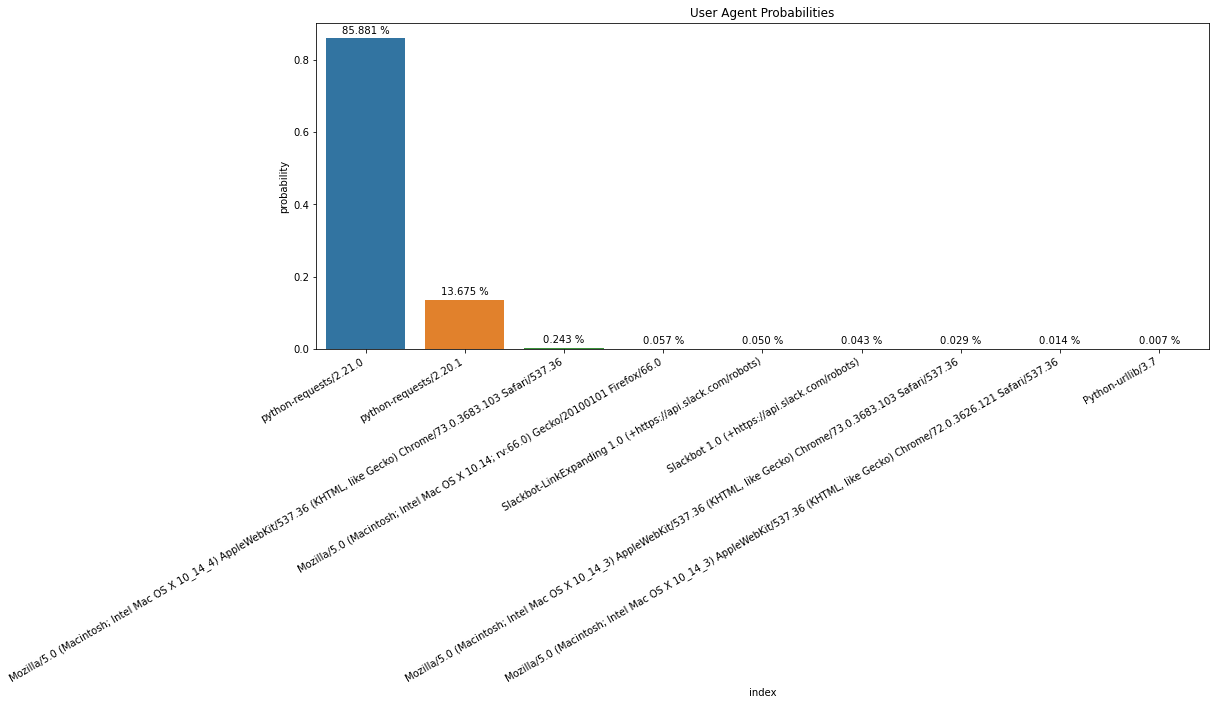

In [38]:
plt.figure(figsize=(16, 6))
splot = sns.barplot(x='index', y='user_agent', data=df.user_agent.value_counts(normalize=True).reset_index().sort_values(
        by='user_agent', ascending=False).head(10))
plt.setp(splot.get_xticklabels(), rotation=30, horizontalalignment='right')
for p in splot.patches:
    splot.annotate(format(p.get_height() * 100, '.3f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
plt.title('User Agent Probabilities')
plt.ylabel('probability')
plt.show()


### Takeaway

None of our user agents indicate an anomaly.

## Size_mb

In [39]:
size_mb = value_counts_and_frequencies(df.size_mb)

In [40]:
size_mb.head()

,count,proba
0.471896,705,0.050451
0.003396,548,0.039216
0.003489,291,0.020824
0.001266,229,0.016388
0.001704,219,0.015672


In [86]:
size_mb.tail()

,count,proba
0.312356,1,0.000072
0.327981,1,0.000072
0.000120,1,0.000072
0.265481,1,0.000072
0.390481,1,0.000072


In [90]:
size_mb[size_mb.proba < 0.003]

,count,proba
0.000000,16,0.001145
0.124856,3,0.000215
0.000046,3,0.000215
0.343606,1,0.000072
0.312356,1,0.000072
0.327981,1,0.000072
0.000120,1,0.000072
0.265481,1,0.000072
0.390481,1,0.000072


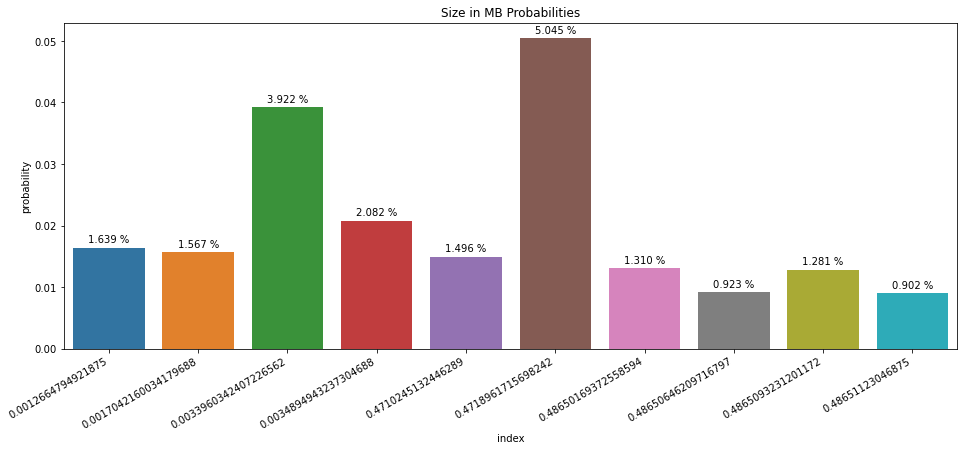

In [41]:
plt.figure(figsize=(16, 6))
splot = sns.barplot(x='index', y='size_mb', data=df.size_mb.value_counts(normalize=True).reset_index().sort_values(
        by='size_mb', ascending=False).head(10))
plt.setp(splot.get_xticklabels(), rotation=30, horizontalalignment='right')
for p in splot.patches:
    splot.annotate(format(p.get_height() * 100, '.3f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
plt.title('Size in MB Probabilities')
plt.ylabel('probability')
plt.show()

### Key Takeaways

The sixteen size 0 values might be anomalies.

## Conditional Probabilities Given IP Address

### Status Code Given IP

In [42]:
status_given_ip = (
    df.groupby('ip')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,status_code,proba_status_given_ip
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [43]:
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,proba_status_given_ip
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167


In [44]:
status_given_ip[status_given_ip.proba_status_given_ip < 1]

,ip,status_code,proba_status_given_ip
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


### Key Takeaway

The values with status code 499 are likely anomalies.

### Request Path Given IP 

In [45]:
request_path_given_ip = (
    df.groupby('ip')
    .request_path.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)

In [46]:
len(request_path_given_ip)

816

In [47]:
request_path_given_ip.head()

,ip,request_path,proba_status_given_ip
0,173.173.113.51,/api/v1/items,0.060434
1,173.173.113.51,/api/v1/items?page=2,0.058546
2,173.173.113.51,/api/v1/items?page=3,0.058546
3,173.173.113.51,/api/v1/stores,0.050992
4,173.173.113.51,/api/v1/sales,0.007554


In [48]:
request_path_given_ip.tail()

,ip,request_path,proba_status_given_ip
811,97.105.19.58,/api/v1/items?page=99999999999999999998,0.000083
812,97.105.19.58,/api/v1/stores?page=2,0.000083
813,97.105.19.58,/api/v1/stores?page=666,0.000083
814,97.105.19.58,/api/v1/stores?page=999,0.000083
815,97.105.19.58,/api/v1items,0.000083


In [49]:
request_path_given_ip.dtypes

ip                        object
request_path              object
proba_status_given_ip    float64
dtype: object

In [50]:
request_path_given_ip[request_path_given_ip['proba_status_given_ip'] == request_path_given_ip['proba_status_given_ip'].min()]

,ip,request_path,proba_status_given_ip
802,97.105.19.58,/api/V1/HiZach!,0.000083
803,97.105.19.58,/api/v1,0.000083
804,97.105.19.58,/api/v1/,0.000083
805,97.105.19.58,/api/v1//api/v1/items,0.000083
806,97.105.19.58,/api/v1//api/v1/items/next_page,0.000083
807,97.105.19.58,/api/v1/I_DIDNT_DO_IT!!!!,0.000083
808,97.105.19.58,/api/v1/helloclass!,0.000083
809,97.105.19.58,/api/v1/items&page=0,0.000083
810,97.105.19.58,/api/v1/items?page=0,0.000083
811,97.105.19.58,/api/v1/items?page=99999999999999999998,0.000083


In [51]:
request_path_given_ip[request_path_given_ip['proba_status_given_ip'] < 0.001]

,ip,request_path,proba_status_given_ip
187,173.173.113.51,/,0.000944
188,173.173.113.51,/documentation,0.000944
793,97.105.19.58,/api/v1//api/v1/items?page=2,0.000833
794,97.105.19.58,/api/v1/items/api/v1/items?page=2,0.000417
795,97.105.19.58,/api/v1/items/next_page,0.000417
796,97.105.19.58,/api/v1/stores?page=3,0.000333
797,97.105.19.58,/api/v1/itemsitems,0.000250
798,97.105.19.58,/api/v1/sales/?page=2,0.000250
799,97.105.19.58,/api/v1/store,0.000250
800,97.105.19.58,/api/v1/stores?page=0,0.000167


In [52]:
request_path_given_ip[request_path_given_ip['proba_status_given_ip'] < 0.005]

,ip,request_path,proba_status_given_ip
5,173.173.113.51,/api/v1/sales?page=10,0.004721
6,173.173.113.51,/api/v1/sales?page=11,0.004721
7,173.173.113.51,/api/v1/sales?page=12,0.004721
8,173.173.113.51,/api/v1/sales?page=13,0.004721
9,173.173.113.51,/api/v1/sales?page=14,0.004721
...,...,...,...
811,97.105.19.58,/api/v1/items?page=99999999999999999998,0.000083
812,97.105.19.58,/api/v1/stores?page=2,0.000083
813,97.105.19.58,/api/v1/stores?page=666,0.000083
814,97.105.19.58,/api/v1/stores?page=999,0.000083


In [53]:
request_path_given_ip[request_path_given_ip['proba_status_given_ip'] < 0.003]

,ip,request_path,proba_status_given_ip
187,173.173.113.51,/,0.000944
188,173.173.113.51,/documentation,0.000944
598,72.181.113.170,/,0.001631
599,72.181.113.170,/favicon.ico,0.001631
792,97.105.19.58,/favicon.ico,0.001167
793,97.105.19.58,/api/v1//api/v1/items?page=2,0.000833
794,97.105.19.58,/api/v1/items/api/v1/items?page=2,0.000417
795,97.105.19.58,/api/v1/items/next_page,0.000417
796,97.105.19.58,/api/v1/stores?page=3,0.000333
797,97.105.19.58,/api/v1/itemsitems,0.000250


### User Agent Given IP

In [54]:
user_agent_given_ip = (
    df.groupby('ip')
    .user_agent.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)

In [55]:
len(user_agent_given_ip)

27

In [56]:
user_agent_given_ip.head()

,ip,user_agent,proba_status_given_ip
0,173.173.113.51,python-requests/2.21.0,1.0
1,24.26.242.9,python-requests/2.21.0,1.0
2,3.88.129.158,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.0
3,3.92.201.136,Slackbot-LinkExpanding 1.0 (+https://api.slack...,1.0
4,34.207.64.242,Slackbot 1.0 (+https://api.slack.com/robots),1.0


In [57]:
user_agent_given_ip.tail()

,ip,user_agent,proba_status_given_ip
22,97.105.19.58,python-requests/2.21.0,0.838306
23,97.105.19.58,python-requests/2.20.1,0.159277
24,97.105.19.58,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002167
25,97.105.19.58,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000167
26,97.105.19.58,Python-urllib/3.7,0.000083


In [58]:
user_agent_given_ip[user_agent_given_ip.proba_status_given_ip != 1.0]

,ip,user_agent,proba_status_given_ip
9,52.87.230.102,Slackbot 1.0 (+https://api.slack.com/robots),0.500000
10,52.87.230.102,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.500000
17,72.181.105.81,python-requests/2.21.0,0.934959
18,72.181.105.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.032520
19,72.181.105.81,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.032520
20,72.181.113.170,python-requests/2.21.0,0.996737
21,72.181.113.170,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.003263
22,97.105.19.58,python-requests/2.21.0,0.838306
23,97.105.19.58,python-requests/2.20.1,0.159277
24,97.105.19.58,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002167


### Size_mb Given IP

In [59]:
size_mb_given_ip = (
    df.groupby('ip')
    .size_mb.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)

In [60]:
len(size_mb_given_ip)

745

In [61]:
size_mb_given_ip.head()

,ip,size_mb,proba_status_given_ip
0,173.173.113.51,0.003396,0.060434
1,173.173.113.51,0.001704,0.058546
2,173.173.113.51,0.003489,0.058546
3,173.173.113.51,0.001266,0.050992
4,173.173.113.51,0.486502,0.013220


In [62]:
size_mb_given_ip.tail()

,ip,size_mb,proba_status_given_ip
740,97.105.19.58,0.000120,0.000083
741,97.105.19.58,0.265481,0.000083
742,97.105.19.58,0.312356,0.000083
743,97.105.19.58,0.327981,0.000083
744,97.105.19.58,0.343606,0.000083


In [63]:
size_mb_given_ip[size_mb_given_ip.proba_status_given_ip < 0.000084]

,ip,size_mb,proba_status_given_ip
740,97.105.19.58,0.000120,0.000083
741,97.105.19.58,0.265481,0.000083
742,97.105.19.58,0.312356,0.000083
743,97.105.19.58,0.327981,0.000083
744,97.105.19.58,0.343606,0.000083


In [64]:
size_mb_given_ip[size_mb_given_ip.proba_status_given_ip < 0.0001]

,ip,size_mb,proba_status_given_ip
740,97.105.19.58,0.000120,0.000083
741,97.105.19.58,0.265481,0.000083
742,97.105.19.58,0.312356,0.000083
743,97.105.19.58,0.327981,0.000083
744,97.105.19.58,0.343606,0.000083


In [65]:
size_mb_given_ip[size_mb_given_ip.proba_status_given_ip < 0.001]

,ip,size_mb,proba_status_given_ip
175,173.173.113.51,0.000040,0.000944
176,173.173.113.51,0.000332,0.000944
177,173.173.113.51,0.390481,0.000944
738,97.105.19.58,0.124856,0.000250
739,97.105.19.58,0.000046,0.000167
740,97.105.19.58,0.000120,0.000083
741,97.105.19.58,0.265481,0.000083
742,97.105.19.58,0.312356,0.000083
743,97.105.19.58,0.327981,0.000083
744,97.105.19.58,0.343606,0.000083


In [66]:
size_mb_given_ip[size_mb_given_ip.proba_status_given_ip < 0.004]

,ip,size_mb,proba_status_given_ip
85,173.173.113.51,0.293963,0.003777
86,173.173.113.51,0.486167,0.003777
87,173.173.113.51,0.486178,0.003777
88,173.173.113.51,0.486183,0.003777
89,173.173.113.51,0.486189,0.003777
...,...,...,...
740,97.105.19.58,0.000120,0.000083
741,97.105.19.58,0.265481,0.000083
742,97.105.19.58,0.312356,0.000083
743,97.105.19.58,0.327981,0.000083


## Conditional Probabilities Given User Agent

### Status Code

In [69]:
status_given_user_agent = (
    df.groupby('user_agent')
    .status_code.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
status_given_user_agent.head()

,user_agent,status_code,proba_status_given_ip
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,200,1.0
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.0
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.0
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,200,1.0
4,Python-urllib/3.7,200,1.0


In [70]:
status_given_user_agent.tail()

,user_agent,status_code,proba_status_given_ip
6,Slackbot-LinkExpanding 1.0 (+https://api.slack...,200,1.000000
7,python-requests/2.20.1,200,0.997907
8,python-requests/2.20.1,499,0.002093
9,python-requests/2.21.0,200,0.999000
10,python-requests/2.21.0,499,0.001000


In [71]:
status_given_user_agent[status_given_user_agent.proba_status_given_ip < 1.0]

,user_agent,status_code,proba_status_given_ip
7,python-requests/2.20.1,200,0.997907
8,python-requests/2.20.1,499,0.002093
9,python-requests/2.21.0,200,0.999000
10,python-requests/2.21.0,499,0.001000


### Request Path

In [73]:
request_path_user_agent = (
    df.groupby('user_agent')
    .request_path.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
request_path_user_agent.head()

,user_agent,request_path,proba_status_given_ip
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,/api/v1/sales,0.250
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,/,0.125
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,/api/v1/items?page=2,0.125
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,/api/v1/items?page=3,0.125
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,/api/v1/items?page=4,0.125


In [74]:
request_path_user_agent.tail()

,user_agent,request_path,proba_status_given_ip
424,python-requests/2.21.0,/api/v1/,0.000083
425,python-requests/2.21.0,/api/v1/items/api/v1/items?page=3,0.000083
426,python-requests/2.21.0,/api/v1/items?page=99999999999999999998,0.000083
427,python-requests/2.21.0,/api/v1/stores?page=0,0.000083
428,python-requests/2.21.0,/api/v1/stores?page=666,0.000083


In [75]:
request_path_user_agent[request_path_user_agent.proba_status_given_ip == request_path_user_agent.proba_status_given_ip.min()]

,user_agent,request_path,proba_status_given_ip
423,python-requests/2.21.0,/api/v1,0.000083
424,python-requests/2.21.0,/api/v1/,0.000083
425,python-requests/2.21.0,/api/v1/items/api/v1/items?page=3,0.000083
426,python-requests/2.21.0,/api/v1/items?page=99999999999999999998,0.000083
427,python-requests/2.21.0,/api/v1/stores?page=0,0.000083
428,python-requests/2.21.0,/api/v1/stores?page=666,0.000083


In [77]:
request_path_user_agent[request_path_user_agent.proba_status_given_ip < 0.001]

,user_agent,request_path,proba_status_given_ip
414,python-requests/2.21.0,/api/v1//api/v1/items?page=2,0.000750
415,python-requests/2.21.0,/api/v1/items/api/v1/items?page=2,0.000500
416,python-requests/2.21.0,/api/v1/items/next_page,0.000417
417,python-requests/2.21.0,/api/v1/stores?page=3,0.000333
418,python-requests/2.21.0,/api/v1/itemsitems,0.000250
419,python-requests/2.21.0,/api/v1/sales/?page=2,0.000250
420,python-requests/2.21.0,/api/v1/store,0.000250
421,python-requests/2.21.0,/api/v1/stores?page=183,0.000167
422,python-requests/2.21.0,/api/v1items,0.000167
423,python-requests/2.21.0,/api/v1,0.000083


### Size_mb

In [80]:
request_path_size_mb = (
    df.groupby('user_agent')
    .size_mb.value_counts(normalize=True)
    .rename('proba_status_given_ip')
    .reset_index()
)
request_path_size_mb.head()

,user_agent,size_mb,proba_status_given_ip
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.471025,0.250
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000040,0.125
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000046,0.125
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000332,0.125
4,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.001266,0.125


In [81]:
request_path_size_mb.tail()

,user_agent,size_mb,proba_status_given_ip
383,python-requests/2.21.0,0.000120,0.000083
384,python-requests/2.21.0,0.312356,0.000083
385,python-requests/2.21.0,0.327981,0.000083
386,python-requests/2.21.0,0.343606,0.000083
387,python-requests/2.21.0,0.390481,0.000083


In [82]:
request_path_size_mb[request_path_size_mb.proba_status_given_ip == request_path_size_mb.proba_status_given_ip.min()]

,user_agent,size_mb,proba_status_given_ip
382,python-requests/2.21.0,0.000046,0.000083
383,python-requests/2.21.0,0.000120,0.000083
384,python-requests/2.21.0,0.312356,0.000083
385,python-requests/2.21.0,0.327981,0.000083
386,python-requests/2.21.0,0.343606,0.000083
387,python-requests/2.21.0,0.390481,0.000083


In [84]:
request_path_size_mb[request_path_size_mb.proba_status_given_ip < 0.001]

,user_agent,size_mb,proba_status_given_ip
201,python-requests/2.20.1,0.265481,0.000523
380,python-requests/2.21.0,0.000000,0.001000
381,python-requests/2.21.0,0.124856,0.000250
382,python-requests/2.21.0,0.000046,0.000083
383,python-requests/2.21.0,0.000120,0.000083
384,python-requests/2.21.0,0.312356,0.000083
385,python-requests/2.21.0,0.327981,0.000083
386,python-requests/2.21.0,0.343606,0.000083
387,python-requests/2.21.0,0.390481,0.000083


## Conclusion 

The values with a very low size and a the values with 0 size and the two status 499 values indicated in our group by IP values are clear outliers.